In [1]:
# a cell full of boilerplate crap.
import torch
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import imageio
import IPython.display as display
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def make_animated_figure(canvas):
    fig, ax = plt.subplots()
    im = ax.imshow(canvas.detach().cpu().numpy())
    plt.tight_layout()
    plt.close(fig)
    return display.display(fig, display_id=True), im, fig
def update_animated_figure(display_handle, im, fig, canvas):
    im.set_data(canvas.detach().cpu().numpy())
    display_handle.update(fig)
def show(i):
    plt.imshow(i.detach().cpu().numpy())    
    plt.show()
def tensor(t):
    return torch.tensor(t,dtype=torch.float32,device=device)
res=64
meshgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, res), torch.linspace(-1, 1, res), indexing='xy'), 2).unsqueeze(0).to(device)

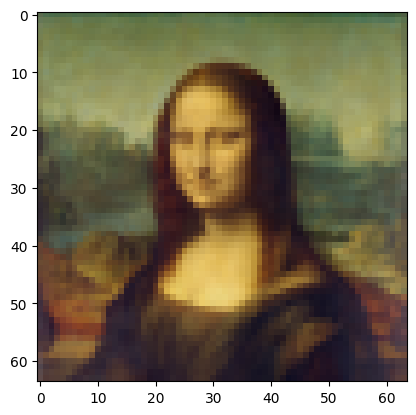

In [2]:
# load the target image and resize it to the target resolution
image = Image.open('monalisa.jpeg').crop((0,0,1280,1280)).resize((res,res))
target=torch.tensor(np.array(image)).to(device)/255.
show(target)
avgcol=torch.mean(target,(0,1), True) * 0.1

In [3]:
# a function to draw a bunch of gaussian blobs and composite them over each other
def draw_blobs(params, brighten=0):
    N=params.shape[0]
    size,ar=params[:, 3],torch.tanh(params[:,4])
    xscale, yscale = torch.exp(-size  + ar), torch.exp(-size - ar)
    c,s=torch.cos(params[:,2]), torch.sin(params[:,2])
    matrices=torch.stack((c*xscale,s*yscale,-s*xscale,c*yscale), axis=-1).reshape(N,2,2)
    rgba = torch.sigmoid(params[:,5:9]+brighten)
    rgba = torch.cat((rgba[..., 0:3] * rgba[..., 3:4], rgba[..., 3:4]), dim=-1)
    x = (meshgrid - params[:, None, None, 0:2])  # translate
    x = torch.einsum('nhwi,nij->nhwj', x, matrices) # rotate
    x = torch.exp(-10 * torch.sum(x * x, 3)) # gaussian
    x=x[..., None] * rgba[:, None, None, :] # tint
    transmittance = 1-x[..., 3:4]
    transmittance = torch.cumprod(transmittance.flip(dims=[0]), 0).flip(dims=[0])   
    x = torch.cat((x[:-1] * transmittance[1:], x[-1].unsqueeze(0)), dim=0)
    return torch.sum(x[...,0:3], axis=0) + avgcol * transmittance[0]

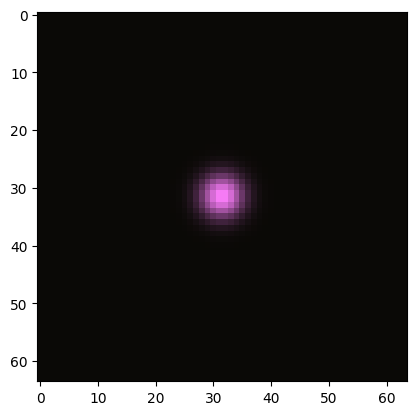

In [4]:
x,y,angle=0,0,0
size,ar=-1,0
r,g,b,a=10,0,10,10
show(draw_blobs(tensor([[x,y,angle,size,ar,r,g,b,a]])))
plt.show()

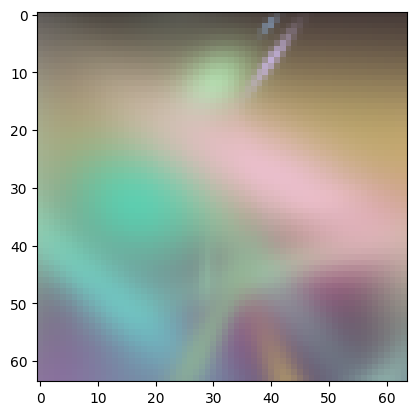

In [5]:
N=30
torch.random.manual_seed(11)
params = torch.nn.Parameter(torch.randn(N, 9,device=device))
canvas=draw_blobs(params, brighten=1)
show(canvas)

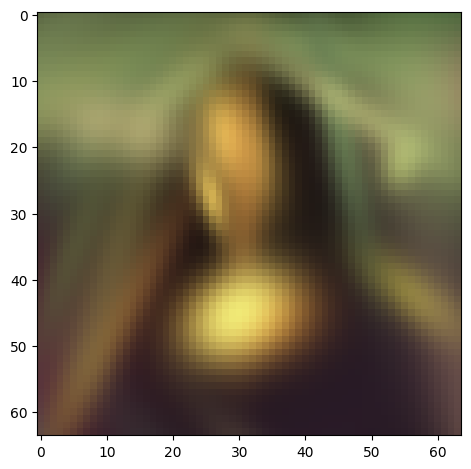

In [6]:
figure = make_animated_figure(canvas)
optimizer = torch.optim.Adam([params], lr=3e-3)  
for iteration in range(2000):
    optimizer.zero_grad()  
    canvas = draw_blobs(params)  
    loss = torch.mean((target - canvas) ** 2)  
    loss.backward()
    optimizer.step()
    if iteration % 10 == 0:  # Print the loss every 100 iterations
        update_animated_figure(*figure, canvas)

In [7]:
gif_path = 'output.mp4'
with imageio.get_writer(gif_path, fps=20) as writer:
    for i in range(1,N+10,1):
        canvas = draw_blobs(params[0:i])
        img = (canvas.detach()*255).to(torch.uint8)
        img = torch.repeat_interleave(img, 4, dim=0)
        img = torch.repeat_interleave(img, 4, dim=1)
        writer.append_data(img.cpu().numpy())
display.display(display.Video(filename=gif_path))

